In [8]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [9]:
def create_image_dataframe(dataset_dir):
    data = []
    image_extensions = ['*.png', '*.jpg', '*.jpeg']
    image_paths = []
    
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(dataset_dir, '**', ext), recursive=True))
    
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        data.append((label, path))
    
    df = pd.DataFrame(data, columns=['label', 'path'])
    return df

In [10]:
dataset_dir = "flowers"
df = create_image_dataframe(dataset_dir)
unique_labels = sorted(df['label'].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
df['label_idx'] = df['label'].map(label_to_index)

In [11]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class FlowerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['label_idx']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [13]:
batch_size = 32
train_dataset = FlowerDataset(train_df, transform=transform)
valid_dataset = FlowerDataset(valid_df, transform=transform)
test_dataset = FlowerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

num_classes = len(unique_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes).to(device)

d:\Users\asas7\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\asas7\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\asas7/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.66MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
epochs = 20
best_val_acc = 0
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
    
    train_acc = train_correct / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")


Epoch 1/20, Loss: 269.0236, Accuracy: 0.7574
Epoch 2/20, Loss: 151.3930, Accuracy: 0.8657
Epoch 3/20, Loss: 122.3325, Accuracy: 0.8901
Epoch 4/20, Loss: 89.3427, Accuracy: 0.9200
Epoch 5/20, Loss: 73.4396, Accuracy: 0.9286
Epoch 6/20, Loss: 56.6928, Accuracy: 0.9484
Epoch 7/20, Loss: 61.4420, Accuracy: 0.9455
Epoch 8/20, Loss: 34.8643, Accuracy: 0.9674
Epoch 9/20, Loss: 38.7475, Accuracy: 0.9628
Epoch 10/20, Loss: 39.9669, Accuracy: 0.9627
Epoch 11/20, Loss: 28.7631, Accuracy: 0.9740
Epoch 12/20, Loss: 27.7702, Accuracy: 0.9746
Epoch 13/20, Loss: 15.3747, Accuracy: 0.9865
Epoch 14/20, Loss: 28.2500, Accuracy: 0.9750
Epoch 15/20, Loss: 33.2115, Accuracy: 0.9715
Epoch 16/20, Loss: 27.5502, Accuracy: 0.9756
Epoch 17/20, Loss: 16.0301, Accuracy: 0.9862
Epoch 18/20, Loss: 27.5002, Accuracy: 0.9748
Epoch 19/20, Loss: 20.8553, Accuracy: 0.9810
Epoch 20/20, Loss: 21.5478, Accuracy: 0.9794


In [17]:
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=unique_labels))

                  precision    recall  f1-score   support

         astilbe       0.90      0.73      0.80       107
      bellflower       0.86      0.67      0.75       144
black_eyed_susan       0.98      0.96      0.97       137
       calendula       0.62      0.86      0.72       140
california_poppy       0.73      0.83      0.78       174
       carnation       0.79      0.70      0.74       141
    common_daisy       0.86      0.91      0.88       152
       coreopsis       0.96      0.74      0.83       160
        daffodil       0.97      0.87      0.92       152
       dandelion       0.94      0.97      0.96       156
            iris       0.92      0.94      0.93       168
        magnolia       0.65      0.86      0.74       146
            rose       0.92      0.67      0.78       150
       sunflower       0.95      0.93      0.94       131
           tulip       0.81      0.97      0.88       151
      water_lily       0.90      0.87      0.88       152

        accu

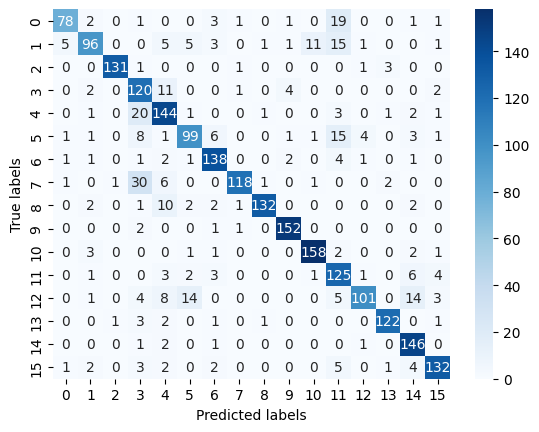

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [19]:
torch.save(model.state_dict(), "RES_FC.pth")